In [1]:
# test pipeline for the bruyere dataset
from fn_cfg import *
import params as cfg

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


['/Volumes/Backup Plus/EEG_Datasets/laurel_place/dataset/0048_2_04092019_1205/0048_2_04092019_1205.bin']
channel P3 utilized
data contains Fz, Cz, Pz & one EOG channel


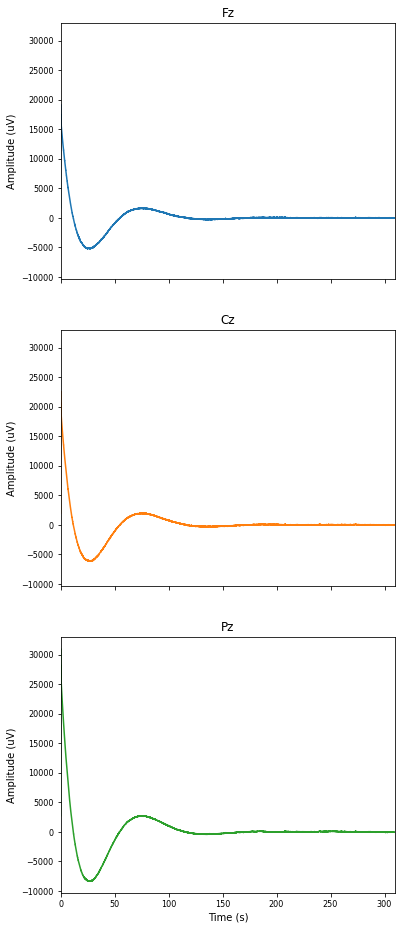

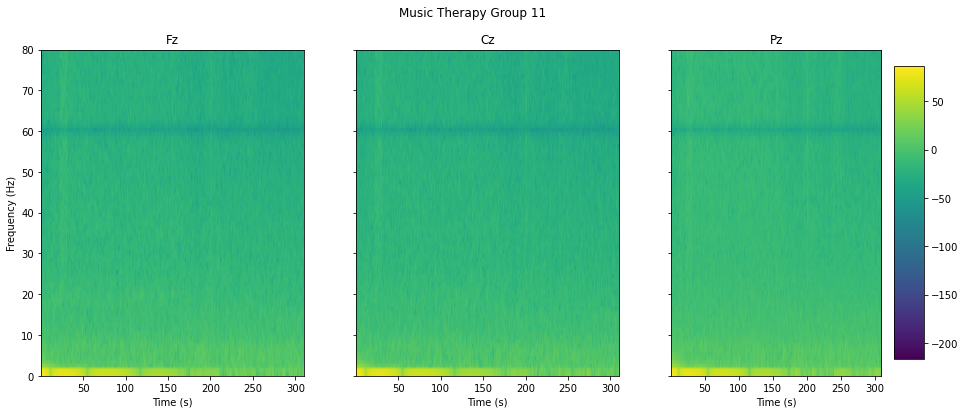

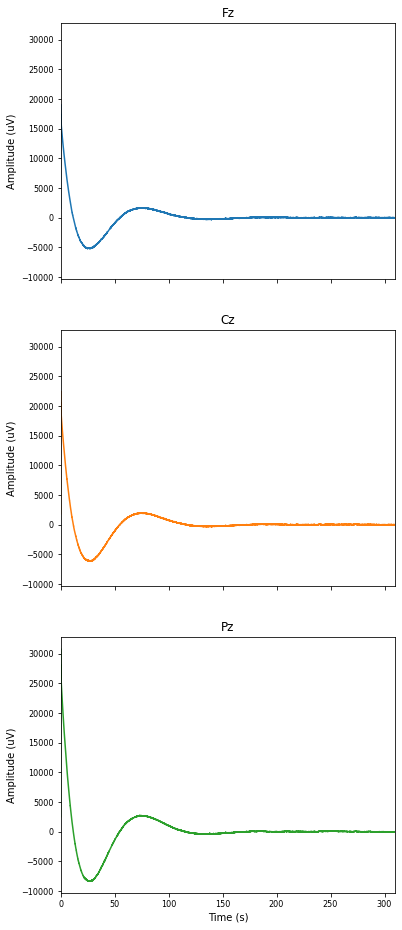

In [2]:
localPath = '/Volumes/Backup Plus/EEG_Datasets/laurel_place/dataset'
filename = '0048_2_04092019_1205'
version = 1.0

#version = 1.1
#filename = '0_1_12072018_1206'
#localPath = '/Users/joshuaighalo/Downloads/raw'

device = importFile.neurocatch()
fileObjects = device.init(version,filename,localPath)
rawEEG = fileObjects[0]
rawEOG = fileObjects[1]
rawEEGEOG = fileObjects[2]
time = fileObjects[3]
trigOutput = fileObjects[4]
plots(time,rawEEG,titles=cfg.channelNames,figsize=cfg.figure_size,pltclr=cfg.plot_color)
spectogramPlot(rawEEG,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=cfg.channelNames,title='Music Therapy Group 11')
filtering = filters()
notchFilterOutput = filtering.notch(rawEEG,line,fs)
plots(time,notchFilterOutput,titles=cfg.channelNames,figsize=cfg.figure_size,pltclr=cfg.plot_color)
#spectogramPlot(notchFilterOutput,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=cfg.channelNames,title='Music Therapy Group 11')


In [3]:
" Functions Utilized"

#   Comparative Study of Wavelet-Based Unsupervised Ocular Artifact Removal Techniques for Single-Channel EEG Data
#   Signal to Artifact Ratio (SAR) is a quantification method to measure the amount of artifact removal 
#   in a specific signal after processing with an algorithm [40].
#   SAR is a measure of the amount of artifact removal in a signal.
#   x = EEG signal containing artifact
#   y = EEG signal obtained after running an artifact free algorithm
def sar(x,y):
    return 10*np.log10((np.std(x))/(np.std(x-y)))
def mse(x,y):
    return math.sqrt(np.square(np.subtract(x,y)).mean())

def DWT(data,time_array):
    #   Probability Mapping Based Artifact Detection and Wavelet Denoising based 
    #   Artifact Removal from Scalp EEG for BCI Applications
    #  Perform DWT on the data
    #   Input: data - EEG data: 1D array (samples x channel)
    #   Output: new signal: (samples x number of wavelets)
    #           signal_global - new signal extracted after global threshold 
    #           signal_std - new signal extracted after std threshold 
    #   Reference:  choice of number of levels to threshold gotten from "Comparative Study of Wavelet-Based Unsupervised 
    #               Ocular Artifact Removal Techniques for Single-Channel EEG Data"
      
    wavelets = ['sym3','coif3','haar','bior4.4'] 
    def dwt_only(data,wavelet):
        def dwt(data,wavelet):
            coeffs = wavedec(data,wavelet,level=10)
            return np.array(coeffs,dtype=object).T

        def global_threshold(data,coeffs):
            def coeffs_approx(data,coeffs):
                return (np.median(abs(coeffs[0]))/0.6745)*(np.sqrt(2*np.log(len(data))))
            def coeffs_detail(data,coeffs):
                return (np.median(abs(coeffs[1]))/0.6745)*(np.sqrt(2*np.log(len(data))))
            arr_approx = coeffs_approx(data,coeffs)
            arr_detail = coeffs_detail(data,coeffs)
            return np.vstack((arr_approx,arr_detail))

        def apply_threshold(coeffs,threshold):
            def apply_threshold_approx(coeffs,threshold):
                coeffs[0][abs(coeffs[0])>threshold[1]] = 0
                coeffs_approx = coeffs[0]
                return coeffs_approx
            def apply_threshold_detail(coeffs,threshold):
                coeffs = coeffs[1:len(coeffs)]
                #coeffs[0][abs(coeffs[0])>threshold[1]] = 0
                #coeffs[1][abs(coeffs[1])>threshold[1]] = 0
                coeffs[2][abs(coeffs[2])>threshold[1]] = 0  # level 8
                coeffs[3][abs(coeffs[3])>threshold[1]] = 0  # level 7
                coeffs[4][abs(coeffs[4])>threshold[1]] = 0  # level 6
                coeffs[5][abs(coeffs[5])>threshold[1]] = 0  # level 5
                coeffs[6][abs(coeffs[6])>threshold[1]] = 0  # level 4
                coeffs[7][abs(coeffs[7])>threshold[1]] = 0  # level 3
                #coeffs[8][abs(coeffs[8])>threshold[1]] = 0
                #coeffs[9][abs(coeffs[9])>threshold[1]] = 0
                return coeffs
            arr_approx = apply_threshold_approx(coeffs,threshold)
            arr_detail = apply_threshold_detail(coeffs,threshold)
            arr_detail = list(np.array(arr_detail).T)
            arr_approx = arr_approx
            coefs = arr_detail
            (coefs).insert(0,arr_approx)
            return coefs

        def inv_dwt(coeffs,wavelet):
            def inverse_dwt(coeffs,wavelet):
                return waverec(coeffs,wavelet)
            arr = (inverse_dwt(list(np.array(coeffs,dtype=object)),wavelet))
            return  (np.array(arr).T)[:-1]

        coeffs = dwt(data,wavelet)
        threshold_global = global_threshold(data,coeffs)
        coeffs_global = apply_threshold(coeffs,threshold_global)
        signal_global = inv_dwt(coeffs_global,wavelet)
        return signal_global

    newEEG_global = []
    for i in range(len(wavelets)):
        newEEG_global.append((dwt_only(data,wavelets[i])))
    newEEG_global = np.array(newEEG_global).T
    if len(newEEG_global) != len(time_array):
        if len(newEEG_global) > len(time_array):
            diff = len(newEEG_global) - len(time_array)
            newEEG_global = newEEG_global[:-diff,:]
        elif len(newEEG_global) < len(time_array):
            diff = len(time_array) - len(newEEG_global)
            num_zeros = np.zeros((diff,len(newEEG_global[1])))
            newEEG_global = np.append(newEEG_global,num_zeros,axis=0)
    else:
        newEEG_global = newEEG_global
    return newEEG_global

SAR sym3 for global threshold:  0.081
SAR coif3 for global threshold:  0.028
SAR haar for global threshold:  0.025
SAR bior4.4 for global threshold:  0.059
MSE sym3 for global threshold:  2553.055
MSE coif3 for global threshold:  2584.461
MSE haar for global threshold:  2586.552
MSE bior4.4 for global threshold:  2566.402


number of std tone event codes: 220
callback! epochs lost for std tone: 58.00%
number of dev tone event codes: 20
callback! epochs lost for dev tone: 40.00%
number of con word event codes: 30
callback! epochs lost for con word: 76.00%
number of inc word event codes: 30
callback! epochs lost for inc word: 46.00%


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


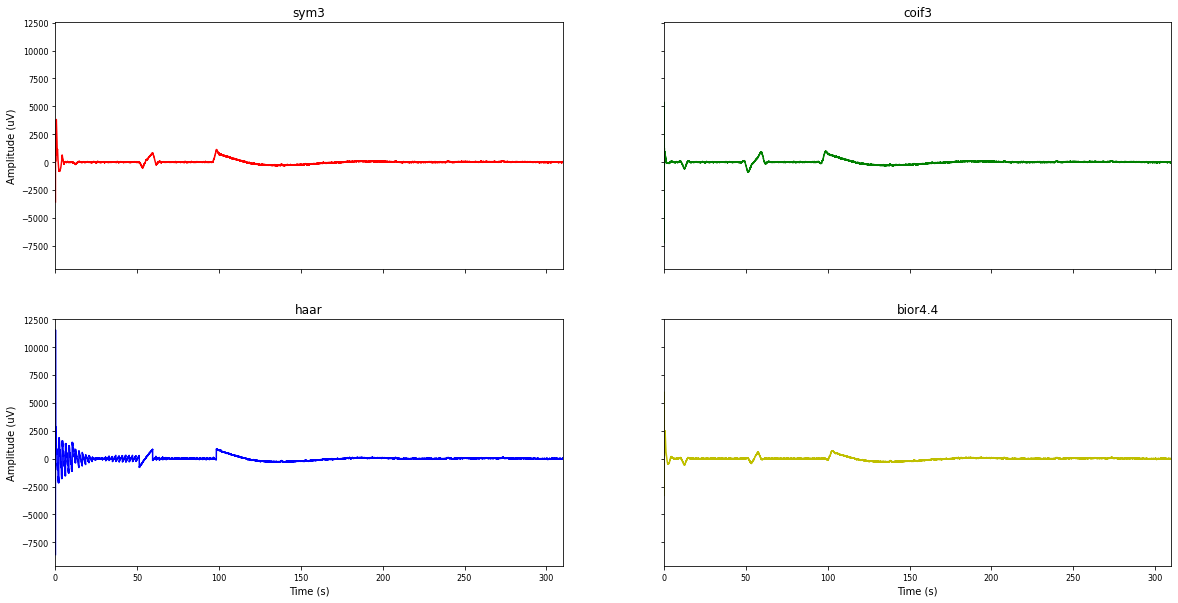

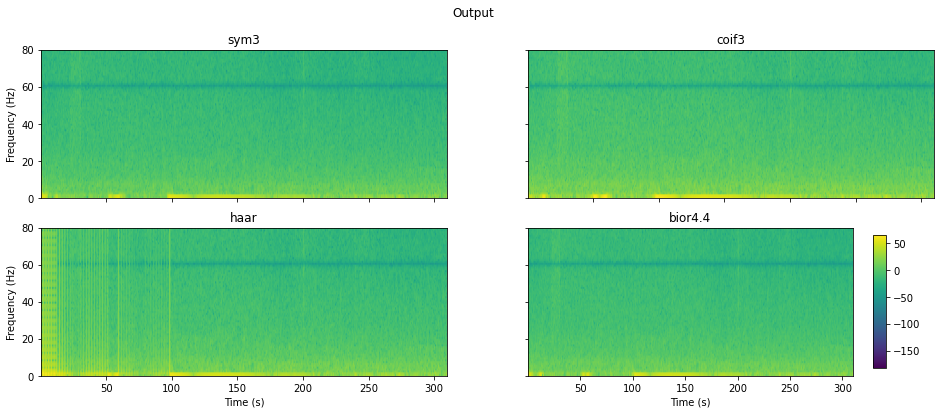

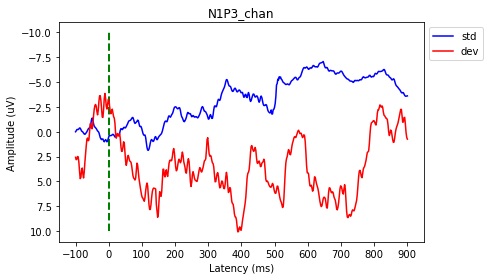

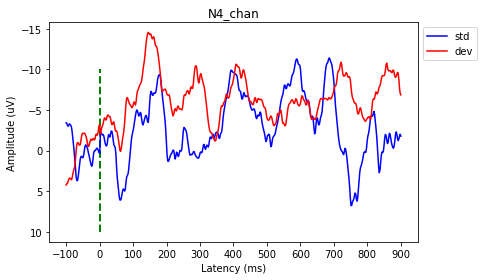

In [4]:
"DWT only"
data = notchFilterOutput[:,1]
dwt_eeg_gt = DWT(data,time)
plots(time,dwt_eeg_gt,['sym3','coif3','haar','bior4.4'],(20,10),['r','g','b','y'])

print("SAR sym3 for global threshold: ", round(sar(data,dwt_eeg_gt[:,0]),3))
print("SAR coif3 for global threshold: ", round(sar(data,dwt_eeg_gt[:,1]),3))
print("SAR haar for global threshold: ", round(sar(data,dwt_eeg_gt[:,2]),3))
print("SAR bior4.4 for global threshold: ", round(sar(data,dwt_eeg_gt[:,3]),3))
print("MSE sym3 for global threshold: ", round(mse(data,dwt_eeg_gt[:,0]),3))
print("MSE coif3 for global threshold: ", round(mse(data,dwt_eeg_gt[:,1]),3))
print("MSE haar for global threshold: ", round(mse(data,dwt_eeg_gt[:,2]),3))
print("MSE bior4.4 for global threshold: ", round(mse(data,dwt_eeg_gt[:,3]),3))

spectogramPlot(dwt_eeg_gt,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=['sym3','coif3','haar','bior4.4'],title='Output')

print("\n")

data_ = dwt_eeg_gt[:,2]
data_ = data_.reshape(data_.shape[0],1)
erps = erpExtraction()
N1P3 = erps.N100P300(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N4 = erps.N400(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N1P3_chan = N1P3[0]
N4_chan = N4[0]
erp_latency = np.array(np.linspace(start=-100, stop=900, num=len(N1P3_chan[0]),dtype=object),dtype=object)
plot_ERPs(N1P3_chan[0],N1P3_chan[1],erp_latency,'N1P3_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)
plot_ERPs(N4_chan[0],N4_chan[1],erp_latency,'N4_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)

SAR sym3 for global threshold:  0.015
SAR coif3 for global threshold:  0.028
SAR haar for global threshold:  0.033
SAR bior4.4 for global threshold:  0.003
MSE sym3 for global threshold:  2592.317
MSE coif3 for global threshold:  2584.659
MSE haar for global threshold:  2581.221
MSE bior4.4 for global threshold:  2599.605


number of std tone event codes: 220
callback! epochs lost for std tone: 20.00%
number of dev tone event codes: 20
callback! epochs lost for dev tone: 35.00%
number of con word event codes: 30
callback! epochs lost for con word: 40.00%
number of inc word event codes: 30
callback! epochs lost for inc word: 20.00%


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


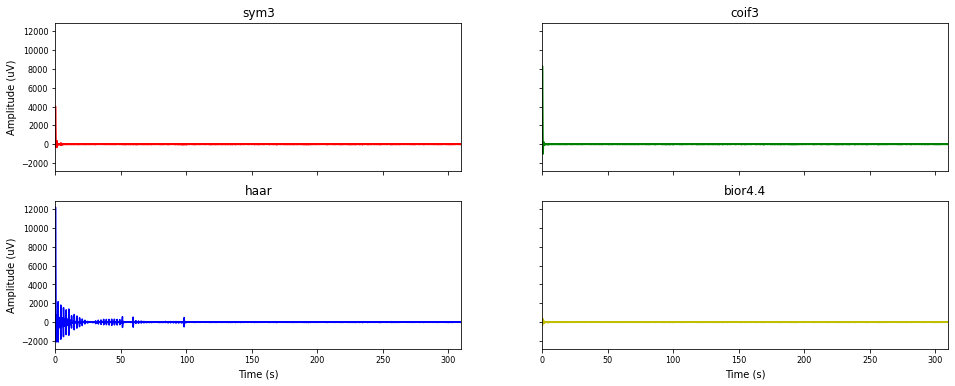

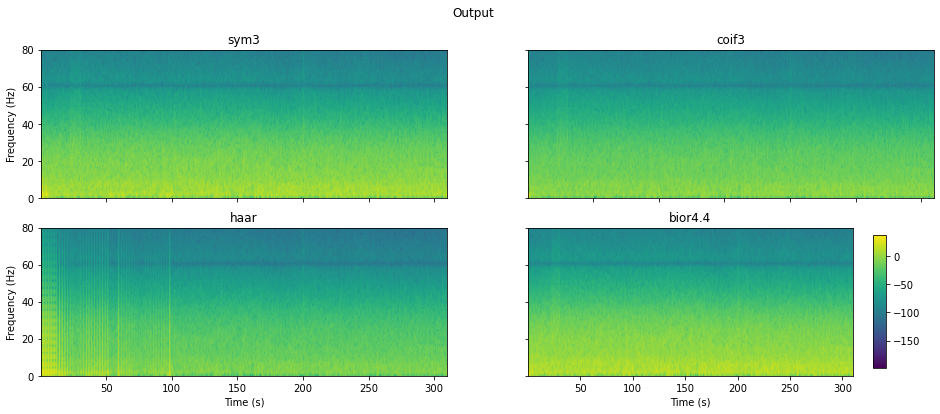

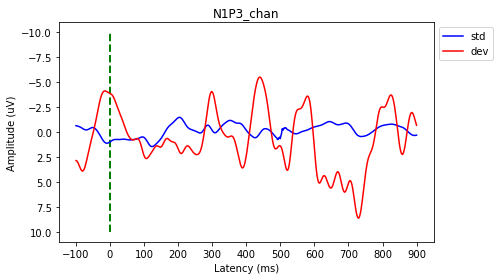

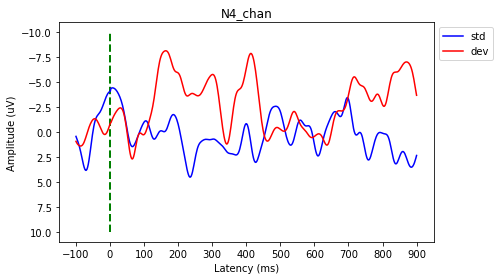

In [5]:
"DWT + BandPass Filter"

bandPassFilterOutput = filtering.butterBandPass(dwt_eeg_gt,lowcut=cfg.highPass,highcut=cfg.lowPass,fs=cfg.fs)
plots(time,bandPassFilterOutput,titles=['sym3','coif3','haar','bior4.4'],figsize=(16,6),pltclr=['r','g','b','y'])

print("SAR sym3 for global threshold: ", round(sar(data,bandPassFilterOutput[:,0]),3))
print("SAR coif3 for global threshold: ", round(sar(data,bandPassFilterOutput[:,1]),3))
print("SAR haar for global threshold: ", round(sar(data,bandPassFilterOutput[:,2]),3))
print("SAR bior4.4 for global threshold: ", round(sar(data,bandPassFilterOutput[:,3]),3))
print("MSE sym3 for global threshold: ", round(mse(data,bandPassFilterOutput[:,0]),3))
print("MSE coif3 for global threshold: ", round(mse(data,bandPassFilterOutput[:,1]),3))
print("MSE haar for global threshold: ", round(mse(data,bandPassFilterOutput[:,2]),3))
print("MSE bior4.4 for global threshold: ", round(mse(data,bandPassFilterOutput[:,3]),3))

spectogramPlot(bandPassFilterOutput,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=['sym3','coif3','haar','bior4.4'],title='Output')

print("\n")

data_ = bandPassFilterOutput[:,2]
data_ = data_.reshape(data_.shape[0],1)
erps = erpExtraction()
N1P3 = erps.N100P300(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N4 = erps.N400(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N1P3_chan = N1P3[0]
N4_chan = N4[0]
erp_latency = np.array(np.linspace(start=-100, stop=900, num=len(N1P3_chan[0]),dtype=object),dtype=object)
plot_ERPs(N1P3_chan[0],N1P3_chan[1],erp_latency,'N1P3_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)
plot_ERPs(N4_chan[0],N4_chan[1],erp_latency,'N4_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)

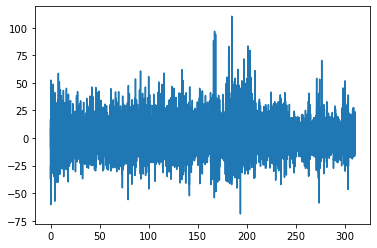



SAR Adap-Band Filtered:  -0.0


number of std tone event codes: 220
callback! epochs lost for std tone: 11.00%
number of dev tone event codes: 20
callback! epochs lost for dev tone: 30.00%
number of con word event codes: 30
callback! epochs lost for con word: 26.00%
number of inc word event codes: 30
callback! epochs lost for inc word: 20.00%


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


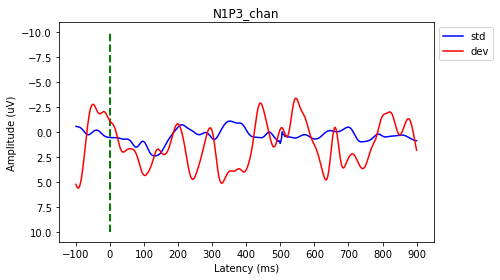

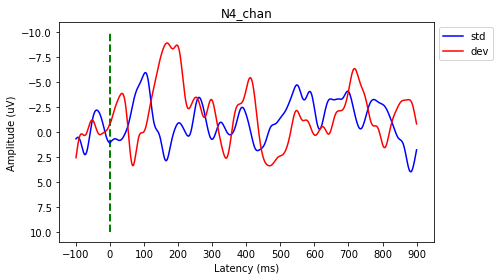

In [6]:
"Adaptive Filter + Band Pass Filter"
data_cz = notchFilterOutput[:,1].reshape(notchFilterOutput[:,1].shape[0],1)
adaptiveFilter_ = filtering.adaptive(data_cz,rawEOG)
bandPassFilter_ = filtering.butterBandPass(adaptiveFilter_,lowcut=cfg.highPass,highcut=cfg.lowPass,fs=cfg.fs)
plt.plot(time,bandPassFilter_)
plt.show()

print("\n")

print("SAR Adap-Band Filtered: ", round(sar(data.reshape(len(data),1),bandPassFilter_),3))

print("\n")

data_ = bandPassFilter_
data_ = data_.reshape(data_.shape[0],1)
erps = erpExtraction()
N1P3 = erps.N100P300(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N4 = erps.N400(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N1P3_chan = N1P3[0]
N4_chan = N4[0]
erp_latency = np.array(np.linspace(start=-100, stop=900, num=len(N1P3_chan[0]),dtype=object),dtype=object)
plot_ERPs(N1P3_chan[0],N1P3_chan[1],erp_latency,'N1P3_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)
plot_ERPs(N4_chan[0],N4_chan[1],erp_latency,'N4_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)

SAR sym3 for global threshold:  -0.0
SAR coif3 for global threshold:  0.0
SAR haar for global threshold:  -0.002
SAR bior4.4 for global threshold:  0.0
MSE sym3 for global threshold:  2601.207
MSE coif3 for global threshold:  2600.965
MSE haar for global threshold:  2602.644
MSE bior4.4 for global threshold:  2600.956


number of std tone event codes: 220
callback! epochs lost for std tone: 15.00%
number of dev tone event codes: 20
callback! epochs lost for dev tone: 35.00%
number of con word event codes: 30
callback! epochs lost for con word: 23.00%
number of inc word event codes: 30
callback! epochs lost for inc word: 13.00%


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


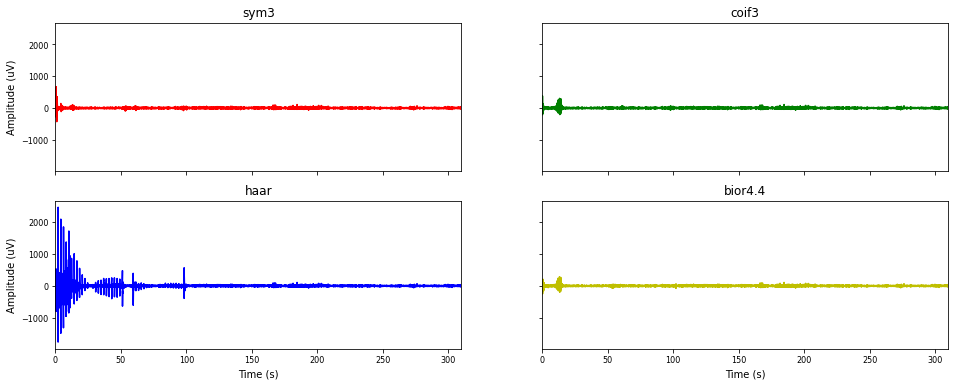

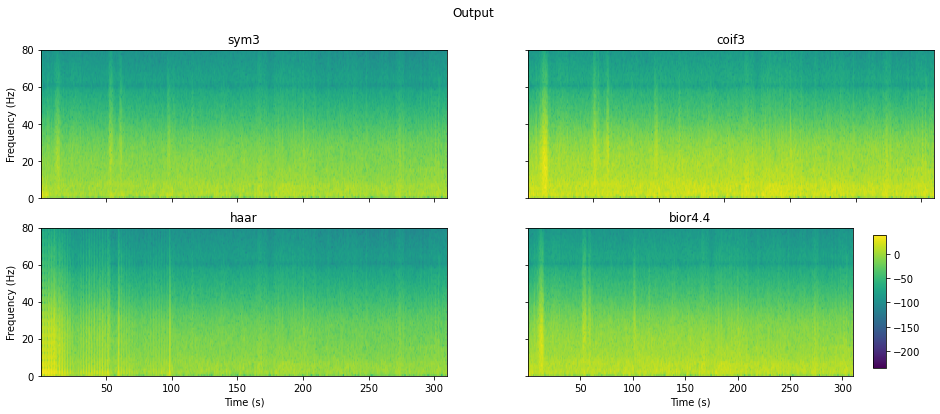

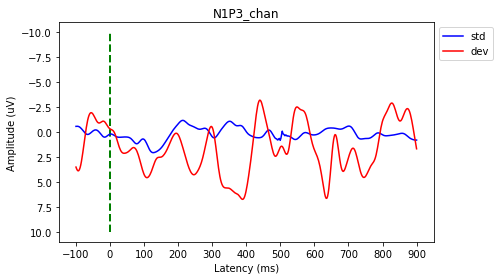

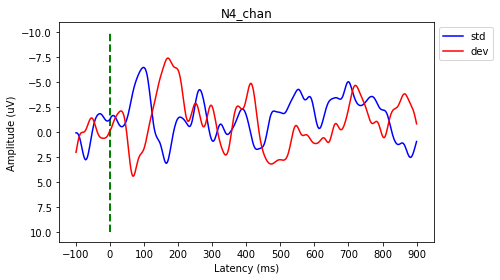

In [7]:
"DWT + Adaptive Filter + Band Pass Filter"
adaptiveFilterOutput = filtering.adaptive(dwt_eeg_gt,rawEOG)
bandPassFilter_Output = filtering.butterBandPass(adaptiveFilterOutput,lowcut=cfg.highPass,highcut=cfg.lowPass,fs=cfg.fs)
plots(time,bandPassFilter_Output,titles=['sym3','coif3','haar','bior4.4'],figsize=(16,6),pltclr=['r','g','b','y'])

print("SAR sym3 for global threshold: ", round(sar(data,bandPassFilter_Output[:,0]),3))
print("SAR coif3 for global threshold: ", round(sar(data,bandPassFilter_Output[:,1]),3))
print("SAR haar for global threshold: ", round(sar(data,bandPassFilter_Output[:,2]),3))
print("SAR bior4.4 for global threshold: ", round(sar(data,bandPassFilter_Output[:,3]),3))
print("MSE sym3 for global threshold: ", round(mse(data,bandPassFilter_Output[:,0]),3))
print("MSE coif3 for global threshold: ", round(mse(data,bandPassFilter_Output[:,1]),3))
print("MSE haar for global threshold: ", round(mse(data,bandPassFilter_Output[:,2]),3))
print("MSE bior4.4 for global threshold: ", round(mse(data,bandPassFilter_Output[:,3]),3))

spectogramPlot(bandPassFilter_Output,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=['sym3','coif3','haar','bior4.4'],title='Output')

print("\n")

data_ = bandPassFilter_Output[:,1]
data_ = data_.reshape(data_.shape[0],1)
erps = erpExtraction()
N1P3 = erps.N100P300(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N4 = erps.N400(trigOutput,data_,time,stimTrig=cfg.stimTrig,clip=cfg.clip)
N1P3_chan = N1P3[0]
N4_chan = N4[0]
erp_latency = np.array(np.linspace(start=-100, stop=900, num=len(N1P3_chan[0]),dtype=object),dtype=object)
plot_ERPs(N1P3_chan[0],N1P3_chan[1],erp_latency,'N1P3_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)
plot_ERPs(N4_chan[0],N4_chan[1],erp_latency,'N4_chan','Latency (ms)','Amplitude (uV)','std','dev','b','r',10)